In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from genelife import *

## Initialization

See additional discussion in the [genelife wiki](https://github.com/js1200/genelife/wiki/Probability-parameters-in-genelife).

The code determining the effect of genes on birth, and the mutation of genomes is currently on lines 229-242 of `subgene.c`.

* param `rulemod=1` => genetically alteration of GOL rule kicks in

Five replication schemes for case of 3 live nbrs:
* repscheme == 0: random choice of live nbr for replication 
* repscheme == 1: deterministic bitwise XOR, replication of 'most different' live nbr
* repscheme == 2: deterministic consensus seq, replication of 'most different' live nbr
* repscheme == 3: deterministic choice: replication of live nbr with unique position
* repscheme == 4: same as 3, more complex version, using rotations.


* `selection == 0` neutral: GoL rule departures depend only on seq diversity
* `selection == 1` select based on `nones` = distance of seq to all 1's 
* `selection == 2` select based on `nones` = min num of 1's in 3 nbr seqs


* param `nlog2p0` fixes probability that
    * compute `nlog2p = nlog2p0 + nones`
    * set `r1=1`  if lowest `nlog2p` bits of `randnr` are 0 (i.e. 1 with probability $1/2^{\rm nlog2p}$
    * birth if empty and ((s==3) or (s==2 and `r1`)) 
* param `nlog2pmut` fixes mutation probability

In [3]:
offsets = [[0,0,0],
       [-1, 0, 0],
       [-1, 1, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 0],
       [1, -1, 0],
       [0, -1, 0],
       [-1, -1, 0]]
numHis = pow(2,len(offsets))
histo=np.zeros(numHis,np.uint64)
flatoff =  [x for sublist in offsets for x in sublist]
npoffsets = np.array(flatoff,np.int32)

runparams = np.zeros(3,np.int32)
simparams = np.zeros(5,np.int32)    # 5 parameters passed to C

Note:  to get the nices possible display, go to the [this site ](http://www.infobyip.com/detectmonitordpi.php) to set `my_dpi` in the next cell properly for your display.

In [4]:
# for my_dpi go to http://www.infobyip.com/detectmonitordpi.php
my_dpi=96

Following animation cell is set up to display for `ndisp` time steps, run without display for `nskip` time steps, and repeat, up to a total of `niter*ndisp` frames displayed (`niter*(ndisp+nskip)` total time steps):

|---`ndisp`---|------------------`nskip`---------------| ... repeated for `niter` times


In [7]:
#def doanimation(nrun=1,ndisp=1000,niter=1):    
nrun=1; nskip = 500; ndisp=100; niter=3
cnt=0
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
#ax.axis('off')

colorgrid(N)
def update_anim(data):
    global gol, cgrid
    global golg
    global log2N
    global simparams
    global cnt
    global framenr
    global mat
    cnt = cnt+1
    if cnt % ndisp == 0:  # insert the non-displayed iterations
        genelife.genelife_update(nskip, 0)
    genelife.genelife_update(nrun, 0)
    genelife.get_curgol(gol)
    genelife.get_curgolg(golg)
    framenr = framenr+nrun
    colorgrid(N)
    mat.set_data(cgrid)
    time_text.set_text('cnt = %.1d' % framenr)
    time_text.set_color('w')
    return mat


<IPython.core.display.Javascript object>


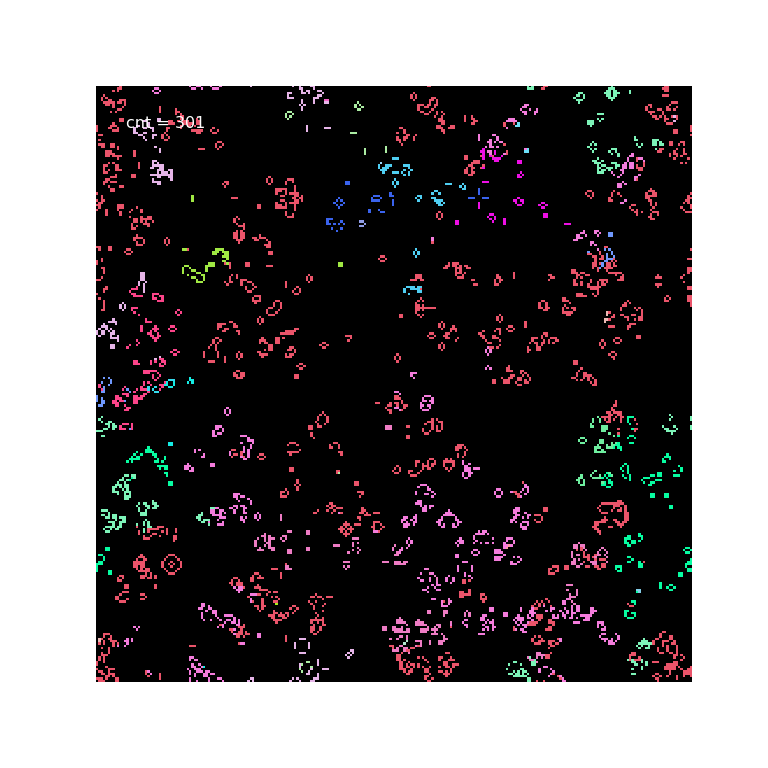

In [8]:
rulemod = runparams[0] = 1          # 0,1
repscheme = runparams[1] = 3        # 0-4
selection = runparams[2] = 1        # 0-2
nlog2p0   = simparams[0] = 8        # base prob of GOL departure 1/2^nlog2p0
nlog2pmut = simparams[1] = 8        # gene mutation probability
nloglog2p1 = simparams[2] = 2       # set baseline for prob of GOL departure due to genes
initial1density = simparams[3] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[4] = 16384   # initial density of random genes
# 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
genelife.initialize_genes(simparams)
framenr = 0

fig, ax = plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
ax.axis('off')
mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
ani = animation.FuncAnimation(fig, update_anim, interval=1, # ~60 ms to see every time step
                              save_count=0, frames=niter*ndisp, repeat = False)
plt.show()